## Import Libraries

In [ ]:
pip install pgmpy

In [ ]:
# Import libraries
from pgmpy.models import BayesianModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pgmpy.factors.discrete import TabularCPD
import numpy as np

plt.style.use('ggplot')

## Definition of the Model

In [ ]:
model = BayesianModel([
                       ('Positive_To_Covid', 'Persistent_Cough'),
                       ('Positive_To_Covid', 'Fever_Above_38'),
                       ('Positive_To_Covid', 'Loss_Taste'),
                       ('Positive_To_Covid', 'Loss_Smell'),
                       ('Over_Eighty', 'Vaccinated'),
                       ('Over_Eighty', 'Live_With_Other_People'),
                       ('Live_With_Other_People', 'Positive_To_Covid'),
                       ('Vaccinated', 'Positive_To_Covid')
                       ])

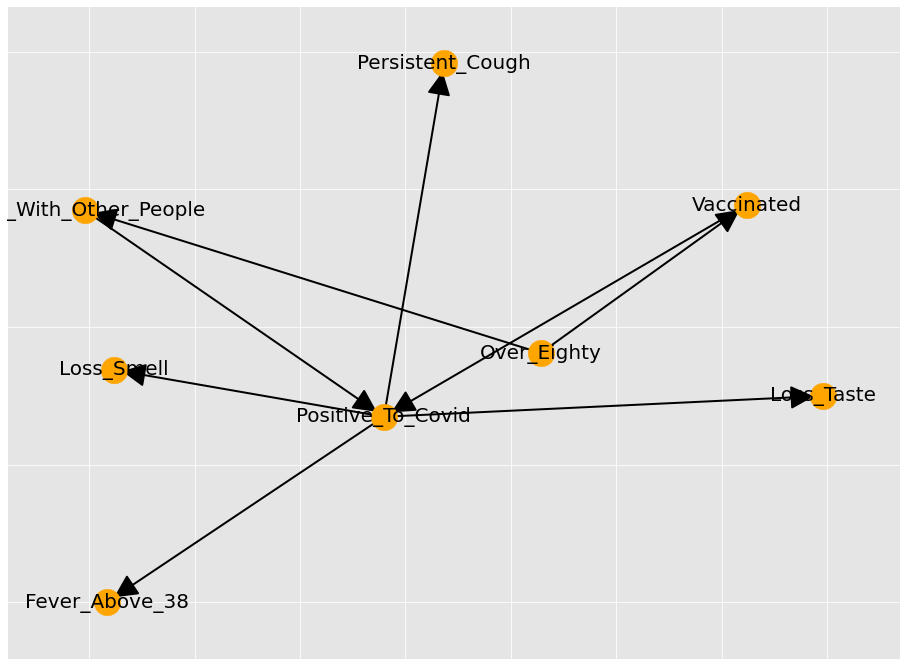

In [ ]:
# network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())

DAG = nx.DiGraph()
DAG.add_edges_from(edges)
fig = plt.figure(figsize = (16,12))
pos = nx.spring_layout(DAG, k=1, iterations=20)

#pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='orange', node_size=700)
nx.draw_networkx_labels(DAG, pos=pos, font_size=20)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='black', width = 2, arrows=True, arrowsize=50)
plt.show()

## Conditional Probability Tables (CPT)

In [ ]:
# Covid patients that had lost taste
loss_taste_cdp = TabularCPD(variable='Loss_Taste', variable_card=2, 
                            values=[[0.9, 0.43],
                                    [0.1, 0.57]],
                            evidence=['Positive_To_Covid'],
                            evidence_card=[2],
                            state_names={'Loss_Taste': ['No', 'Yes'],
                                         'Positive_To_Covid': ['No', 'Yes']})

# Covid patients that had lost smell
loss_smell_cdp = TabularCPD(variable='Loss_Smell', variable_card=2, 
                            values=[[0.85, 0.46],
                                    [0.15, 0.54]],
                            evidence=['Positive_To_Covid'],
                            evidence_card=[2],
                            state_names={'Loss_Smell': ['No', 'Yes'],
                                         'Positive_To_Covid': ['No', 'Yes']})


# Covid patients that had fever above 38˚C
fever_cdp = TabularCPD(variable='Fever_Above_38', variable_card=2, 
                            values=[[0.82, 0.3],
                                    [0.18, 0.7]],
                            evidence=['Positive_To_Covid'],
                            evidence_card=[2],
                            state_names={'Fever_Above_38': ['No', 'Yes'],
                                         'Positive_To_Covid': ['No', 'Yes']})


# Covid patients that had persistent cough
cough_cpd = TabularCPD(variable='Persistent_Cough', variable_card=2, 
                            values=[[0.75, 0.2],
                                    [0.25, 0.8]],
                            evidence=['Positive_To_Covid'],
                            evidence_card=[2],
                            state_names={'Persistent_Cough': ['No', 'Yes'],
                                         'Positive_To_Covid': ['No', 'Yes']})

# is not/is over eighty
over_eighty_cpd = TabularCPD(variable='Over_Eighty', variable_card=2, 
                             values=[[0.93], [0.07]],
                             state_names={'Over_Eighty': ['No', 'Yes']})

# is not/is vaccinated, given over eighty
vaccinated_cpd = TabularCPD(variable='Vaccinated', variable_card=2, 
                            values=[[0.92, 0.57],
                                    [0.08, 0.43]],
                            evidence=['Over_Eighty'],
                            evidence_card=[2],
                            state_names={'Vaccinated': ['No', 'Yes'],
                                         'Over_Eighty': ['No', 'Yes']})

# live with other people
live_with_other_people_cpd = TabularCPD(variable='Live_With_Other_People', 
                            variable_card=2, 
                            values=[[0.35, 0.55],
                                    [0.65, 0.45]],
                            evidence=['Over_Eighty'],
                            evidence_card=[2],
                            state_names={'Live_With_Other_People': ['No', 'Yes'],
                                        'Over_Eighty': ['No', 'Yes']})
# is positive to Covid
positive_to_covid_cpd = TabularCPD(variable='Positive_To_Covid', 
                            variable_card=2, 
                            values=[[0.88, 0.98, 0.82, 0.94],
                                    [0.12, 0.02, 0.18, 0.06]],
                            evidence=['Live_With_Other_People', 'Vaccinated'],
                            evidence_card=[2, 2],
                            state_names={'Live_With_Other_People': ['No', 'Yes'],
                                         'Vaccinated': ['No', 'Yes'],
                                         'Positive_To_Covid': ['No', 'Yes']})

In [ ]:
# Add the Conditional Probability Tables to the model
model.add_cpds(loss_taste_cdp,
               loss_smell_cdp,
               fever_cdp,
               cough_cpd,
               over_eighty_cpd,
               vaccinated_cpd,
               live_with_other_people_cpd,
               positive_to_covid_cpd)
# Check if it sum up to 1 => if the CPT’s are defined correctly.
model.check_model()

True

### Viewing the Conditional Probability Tables

In [ ]:
# Print the Conditional Probability Tables

print('CPT - Over_Eighty')
print(over_eighty_cpd)
print()

print('CPT - Vaccinated')
print(vaccinated_cpd)
print()

print('CPT - Live_With_Other_People')
print(live_with_other_people_cpd)
print()

print('CPT - Positive_To_Covid')
print(positive_to_covid_cpd)
print()

print('CPT - Loss_Taste')
print(loss_taste_cdp)
print()

print('CPT - Loss_Smell')
print(loss_smell_cdp)
print()

print('CPT - Fever_Above_38')
print(fever_cdp)
print()

print('CPT - Persistent_Cough')
print(cough_cpd)
print()

CPT - Over_Eighty
+------------------+------+
| Over_Eighty(No)  | 0.93 |
+------------------+------+
| Over_Eighty(Yes) | 0.07 |
+------------------+------+

CPT - Vaccinated
+-----------------+-----------------+------------------+
| Over_Eighty     | Over_Eighty(No) | Over_Eighty(Yes) |
+-----------------+-----------------+------------------+
| Vaccinated(No)  | 0.92            | 0.57             |
+-----------------+-----------------+------------------+
| Vaccinated(Yes) | 0.08            | 0.43             |
+-----------------+-----------------+------------------+

CPT - Live_With_Other_People
+-----------------------------+-----------------+------------------+
| Over_Eighty                 | Over_Eighty(No) | Over_Eighty(Yes) |
+-----------------------------+-----------------+------------------+
| Live_With_Other_People(No)  | 0.35            | 0.55             |
+-----------------------------+-----------------+------------------+
| Live_With_Other_People(Yes) | 0.65            | 

## Viewing Independences

In [ ]:
print(model.local_independencies('Vaccinated'))
print(model.local_independencies('Positive_To_Covid'))

(Vaccinated ⟂ Live_With_Other_People | Over_Eighty)
(Positive_To_Covid ⟂ Over_Eighty | Vaccinated, Live_With_Other_People)


## Exact Inference - Variable Elimination

In [ ]:
from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(model)

# the prior probability distribution of Positive_To_Covid
query_positiveness = exact_inference.query(['Positive_To_Covid'])
print('\nP(Positive_To_Covid)\n\n', query_positiveness)

Eliminating: Fever_Above_38: 100%|██████████| 7/7 [00:00<00:00, 371.30it/s]


P(Positive_To_Covid)

 +------------------------+--------------------------+
| Positive_To_Covid      |   phi(Positive_To_Covid) |
+========================+==========================+
| Positive_To_Covid(No)  |                   0.8535 |
+------------------------+--------------------------+
| Positive_To_Covid(Yes) |                   0.1465 |
+------------------------+--------------------------+


In [ ]:
query_positiveness_give_symptoms = exact_inference.query(['Positive_To_Covid'],
                                                         {'Loss_Smell':'Yes',
                                                          'Loss_Taste': 'Yes'})
print('\n\nP( Positive_To_Covid | Loss_Smell = Yes )\n\n', query_positiveness_give_symptoms)

Eliminating: Fever_Above_38: 100%|██████████| 5/5 [00:00<00:00, 347.26it/s]



P( Positive_To_Covid | Loss_Smell = Yes )

 +------------------------+--------------------------+
| Positive_To_Covid      |   phi(Positive_To_Covid) |
+========================+==========================+
| Positive_To_Covid(No)  |                   0.2212 |
+------------------------+--------------------------+
| Positive_To_Covid(Yes) |                   0.7788 |
+------------------------+--------------------------+


In [ ]:
query_positiveness_given_vaccinated = exact_inference.query(['Positive_To_Covid'],{'Vaccinated':'Yes'})
print('\n\nP( Positive_To_Covid | Vaccinated = Yes )\n\n', query_positiveness_given_vaccinated)

Eliminating: Fever_Above_38: 100%|██████████| 6/6 [00:00<00:00, 362.56it/s]



P( Positive_To_Covid | Vaccinated = Yes )

 +------------------------+--------------------------+
| Positive_To_Covid      |   phi(Positive_To_Covid) |
+========================+==========================+
| Positive_To_Covid(No)  |                   0.9563 |
+------------------------+--------------------------+
| Positive_To_Covid(Yes) |                   0.0437 |
+------------------------+--------------------------+


In [ ]:
query_map_positiveness_yes = exact_inference.map_query(['Over_Eighty', 'Live_With_Other_People',
                                    'Vaccinated'], {'Positive_To_Covid':'Yes'}) 
print('\n\nMAP of Positive_To_Covid = \"Yes\" \n\n', query_map_positiveness_yes)

Eliminating: Fever_Above_38: 100%|██████████| 4/4 [00:00<00:00, 649.00it/s]



MAP of Positive_To_Covid = "Yes" 

 {'Over_Eighty': 'No', 'Live_With_Other_People': 'Yes', 'Vaccinated': 'No'}


## Approximate Inference

In [ ]:
query_vaccinated_given_eighty_and_positiveness = exact_inference.query(['Vaccinated'], 
                                                                       {'Over_Eighty' : 'Yes',
                                                                        'Positive_To_Covid' : 'No'})
print('\n\n\nExact Inference:')
print("\nP(Vaccinated | Over_Eighty = \"Yes\", Positive_To_Covid = \"No\")\n\n", 
      query_vaccinated_given_eighty_and_positiveness)

result_variable_Elimination = query_vaccinated_given_eighty_and_positiveness.values[1]

Eliminating: Fever_Above_38: 100%|██████████| 5/5 [00:00<00:00, 516.20it/s]




Exact Inference:

P(Vaccinated | Over_Eighty = "Yes", Positive_To_Covid = "No")

 +-----------------+-------------------+
| Vaccinated      |   phi(Vaccinated) |
+=================+===================+
| Vaccinated(No)  |            0.5403 |
+-----------------+-------------------+
| Vaccinated(Yes) |            0.4597 |
+-----------------+-------------------+


In [ ]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

In [ ]:
bms = BayesianModelSampling(model)

In [ ]:
def print_best_approximate_method(result_variable_Elimination, results_Weighed_Likelihood, 
                                  results_Rejection_Sampling):
    wl = abs(result_variable_Elimination - results_Weighed_Likelihood[-1])
    rs = abs(result_variable_Elimination - results_Rejection_Sampling[-1])

    min_error = min(wl, rs)

    if min_error == wl:
        print('Best Approximate Inference method: Weighted Likelihood\nError compared to Variable Elimination: {}'.format(wl))
    else:
        print('Best Approximate Inference method: Rejection Sampling\nError compared to Variable Elimination: {}'.format(rs))

In [ ]:
def weighted_likelihood_method(samples,variable):
    return round(np.sum(np.dot(samples[variable], samples['_weight']))/np.sum(samples['_weight']), 2)

In [ ]:
def run_tests(size):
    # Samples
    samples_Weighed_Likelihood = bms.likelihood_weighted_sample(
                      evidence = evidence, 
                      size=size, 
                      return_type='recarray')
    samples_Rejection_Sampling = bms.rejection_sample(
                      evidence = evidence, 
                      size=size, 
                      return_type='recarray')
    
    # Compute probability
    results_Weighed_Likelihood = weighted_likelihood_method(samples_Weighed_Likelihood,'Vaccinated')
    results_Rejection_Sampling = np.recarray.mean(samples_Rejection_Sampling['Vaccinated'], axis=0)
    
    # Results
    return np.array([(size, 
                      results_Weighed_Likelihood,
                      results_Rejection_Sampling)], 
                    dtype=[('size', '<i8'), ('Weighed_Likelihood', '<f8'),
                           ('Rejection_Sampling', '<f8')])

In [ ]:
approximations = np.array([], dtype=[('size', '<i8'), ('Weighed_Likelihood', '<f8'), 
                                     ('Rejection_Sampling', '<f8')])

In [ ]:
initial_size = 2
final_size = 5
num = 5
evidence = [State('Over_Eighty', 'Yes'), State('Positive_To_Covid', 'No')]

for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    approximations = np.append(approximations, run_tests(size))
    
sizes = approximations['size']
results_Weighed_Likelihood = approximations['Weighed_Likelihood']
results_Rejection_Sampling = approximations['Rejection_Sampling']

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: Persistent_Cough: 100%|██████████| 8/8 [00:00<00:00, 150.50it/s]

Generating for node: Persistent_Cough: 100%|██████████| 8/8 [00:00<00:00, 36.56it/s]
249it [00:00, 855.42it/s]
Generating for node: Persistent_Cough: 100%|██████████| 8/8 [00:00<00:00, 19.35it/s]
832it [00:00, 1478.68it/s]
Generating for node: Persistent_Cough: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]
4557it [00:01, 2392.40it/s]
Generating for node: Persistent_Cough: 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]
25501it [00:09, 2811.89it/s]
Generating for node: Persistent_Cough: 100%|██████████| 8/8 [00:47<00:00,  5.94s/it]
143053it [00:51, 2804.28it/s]


In [ ]:
# The three columns represents the three different Approximate Inference methods,
# while the five rows represent the 5 steps with different number of samples
print(approximations)

[(   100, 0.43, 0.36      ) (   562, 0.47, 0.48576512)
 (  3162, 0.44, 0.46141682) ( 17782, 0.45, 0.45765381)
 (100000, 0.46, 0.46021   )]


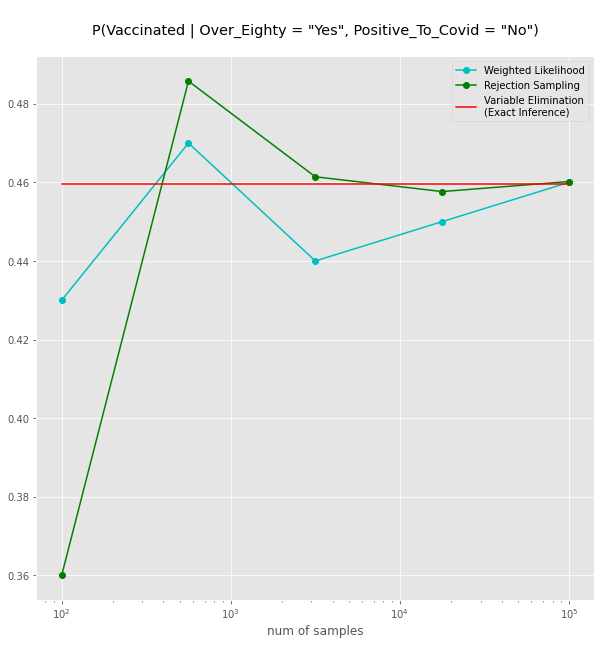

In [ ]:
# Compare the three Approximate Inference methods
plt.figure(figsize=(10,10))
plt.title('\nP(Vaccinated | Over_Eighty = "Yes", Positive_To_Covid = "No")\n')
plt.xlabel("num of samples")

sizes = approximations['size']

plt.semilogx(sizes, results_Weighed_Likelihood, 'co-', label="Weighted Likelihood")
plt.semilogx(sizes, results_Rejection_Sampling, 'go-', label="Rejection Sampling")
plt.semilogx(sizes, result_variable_Elimination * np.ones(len(sizes)),'r', 
             label="Variable Elimination\n(Exact Inference)")

plt.legend()
plt.show()

In [ ]:
print_best_approximate_method(result_variable_Elimination, 
                              results_Weighed_Likelihood, 
                              results_Rejection_Sampling)

Best Approximate Inference method: Weighted Likelihood
Error compared to Variable Elimination: 0.0003113783102003942


In [ ]:
results_Weighed_Likelihood

array([0.43, 0.47, 0.44, 0.45, 0.46])